# 5: Multi Criteria Analysis of Nodes (Hubs)

###### Combine all previous made and normalize the necessary values in order to multiply them by their respective importance value (weight) in order to find the best locations for the HUBS in the given place. Weight and the top number of nodes that is wanted can be altered in the setup below.

### Setting up packages and variables

In [1]:
import osmnx as ox
from sklearn import preprocessing
ox.config(log_console=True, use_cache=True)
ox.__version__
import pandas as pd
ox.config(use_cache=True, log_console=True)
import numpy as np

# configure the place, network type, trip times, and travel speed
place = 'Binnenstad, Delft, Netherlands'

# walking [comment when calculating cycling version]
network_type = 'all'

# theme colors
miev_pink = '#f06675'
miev_blue = '#2c3174'
miev_yellow = '#fbe56d'

# give weights for travel, highway distance and centrality based on importance
weight_travel = 5
weight_highway = 1
weight_centrality = 2

# input to give top amount
top = 200

/root/venv/lib/python3.9/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


### Download network

In [2]:
# download the street network with inner city + 1km buffer
G = ox.graph_from_place(place, network_type, buffer_dist=1000)

### Read all dataframes from previous scripts and merge

In [3]:
# read all data produced
df = pd.read_excel('data/final_distances_citycenter_extracted.xlsx')

df_2 = pd.read_excel('data/final_times_highway_extracted.xlsx')

df_3 = pd.read_excel('data/centrality.xlsx')

In [4]:
# merge datasets
df = df.merge(df_2, on=['Node ID'],how='inner')

df = df.merge(df_3, on=['Node ID'],how='inner')

### Normalize values & multiply by weight

In [5]:
# get lowest highway travel time per node id (quickest way to get into highway amongst all 4)
subset = ["Travel Time HW1","Travel Time HW2", "Travel Time HW3", "Travel Time HW4"]
lowest_HWtraveltime = df[subset].min(numeric_only = True, axis=1)
df["lowest HWtraveltime"] = lowest_HWtraveltime

# centrality is a value that is the higher the better, thus this needs to be reversed to match with the travel times (where lowest is best)
df["Centrality"] = 1- df["Centrality"]

# copy the data
df_min_max_scaled = df.copy(deep=True)
  
# apply normalization techniques by Column 1
column = "Travel Time"
df["Travel Time normalized"] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())    
#df["Travel Time normalized"] = (df_min_max_scaled[column] - df_min_max_scaled[column].mean()) / df_min_max_scaled[column].std()  

# # apply normalization techniques by Column 1
column = "lowest HWtraveltime"
df["Travel Time HW normalized"] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())    
#df["Travel Time HW normalized"] = (df_min_max_scaled[column] - df_min_max_scaled[column].mean()) / df_min_max_scaled[column].std()  


# # # apply normalization techniques by Column 1
column = "Centrality"
df["Centrality normalized"] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())    
#df["Centrality normalized"] = (df_min_max_scaled[column] - df_min_max_scaled[column].mean()) / df_min_max_scaled[column].std()  

# calculate the scores with the given weights
df["score_traveltime"] = df["Travel Time normalized"] * weight_travel
df["score_highway"] = df["Travel Time HW normalized"] * weight_highway
df["score_centrality"] = df["Centrality normalized"] * weight_centrality

# count total score
df["Total Points"] = df["score_traveltime"] + df["score_highway"] + df["score_centrality"]

# drop columns that aren't related to the score but were necessary in the process
droplist = ["Unnamed: 0_x", "Unnamed: 0_y", "Travel Dis", "Unnamed: 0",
                "Travel Time HW1", "Travel Time HW2", "Travel Time HW3", "Travel Time HW4", 
                "Centrality normalized", "Travel Time HW normalized", "Travel Time normalized"]
df = df.drop(columns=droplist)

# Get top and export
df = df.sort_values('Total Points').head(top)
df.to_excel("data/ranked_nodes.xlsx")

In [6]:
# quick view finished & saved dataframe
df

,Node ID,Travel Time,Centrality,lowest HWtraveltime,score_traveltime,score_highway,score_centrality,Total Points
2076,1838103222,6.85,0.747,1.07,0.213746,0.280840,0.000000,0.494586
3295,5664317026,9.06,0.813,0.85,0.474728,0.223097,0.521739,1.219565
563,44877391,11.77,0.772,1.59,0.794757,0.417323,0.197628,1.409708
2078,1838103226,12.16,0.775,1.63,0.840812,0.427822,0.221344,1.489978
1705,1436427125,10.89,0.842,0.58,0.690836,0.152231,0.750988,1.594055
...,...,...,...,...,...,...,...,...
2204,2294926506,11.04,0.999,0.88,0.708550,0.230971,1.992095,2.931616
567,44878166,12.14,0.960,1.56,0.838451,0.409449,1.683794,2.931694
4336,9165850620,10.85,0.999,0.97,0.686112,0.254593,1.992095,2.932800
3901,8573191020,11.31,1.000,0.74,0.740435,0.194226,2.000000,2.934660


### Plot best nodes

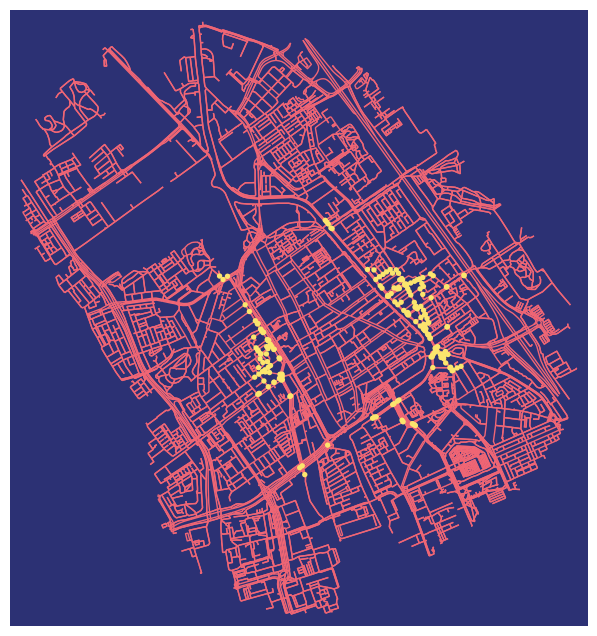

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [7]:
outer_nodes = df['Node ID']

# extract nodes and edges from Graph
nodes, edges = ox.graph_to_gdfs(G)

# make dataframe from extracted nodes
df = nodes

# filter out ID's of top 100 from the nodes
Filter_df  = df[df.index.isin(outer_nodes)]

# make new graph from the new nodes dataframe 
G_final = ox.graph_from_gdfs(Filter_df, edges)

# plot the new graph and save
ox.plot_graph(G_final, filepath='data/ranked_nodes.png', save=True, edge_color=miev_pink, bgcolor=miev_blue, node_color= miev_yellow, node_size = 15)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8966f7b1-6d03-4f20-86ea-afcd52732bbc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>